In [1]:
import torch
import matplotlib
import sklearn
import moviepy

In [2]:
import pandas as pd
import numpy as np

# Cargar el dataset original
df = pd.read_csv("/Users/lucia/.cache/kagglehub/datasets/trisha2094/weatheraus/versions/1/weatherAUS.csv")

# Convertir 'RainTomorrow' a numérico
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})


In [3]:
import torch
from kan import *
import matplotlib.pyplot as plt
import moviepy.video.io.ImageSequenceClip

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [4]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def load_weather_dataset(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Drop 'RISK_MM' column (data leakage)
    df.drop(['RISK_MM'], axis=1, inplace=True)

    # Convert 'Date' to datetime and extract year, month, day
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    # Drop original 'Date' column
    df.drop('Date', axis=1, inplace=True)

    # Handle 'RainToday' & 'RainTomorrow'
    df['RainToday'].fillna('No', inplace=True)  
    df['RainTomorrow'].fillna('No', inplace=True)  # Assume 'No' if missing

    df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1}).astype(int)
    df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(int)  # Target variable

    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()

    # Ensure 'RainTomorrow' is NOT treated as a feature
    num_cols.remove('RainTomorrow') if 'RainTomorrow' in num_cols else None
    cat_cols.remove('RainTomorrow') if 'RainTomorrow' in cat_cols else None

    # Fill missing values
    for col in num_cols:
        df[col].fillna(df[col].mean(), inplace=True)  # Replace missing numerical values with mean

    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)  # Replace missing categorical values with most frequent category

    # Encode categorical features
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store encoders for inverse transformation

    # Select feature columns (all except the target)
    feature_columns = num_cols + cat_cols
    target_column = 'RainTomorrow'

    # Extract data and target
    data = df[feature_columns].values
    target = df[target_column].values

    # Apply MinMaxScaler to scale numerical features to range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(
        data_tensor, target_tensor, test_size=0.2, random_state=42
    )

    # Create PyTorch dataloaders
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False
    )

    # Create empty tensors
    train_inputs = torch.empty(0, len(feature_columns), device='cpu')
    train_labels = torch.empty(0, dtype=torch.long, device='cpu')
    test_inputs = torch.empty(0, len(feature_columns), device='cpu')
    test_labels = torch.empty(0, dtype=torch.long, device='cpu')

    # Concatenate all data into a single tensor on the specified device
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to('cpu')), dim=0)
        train_labels = torch.cat((train_labels, labels.to('cpu')), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to('cpu')), dim=0)
        test_labels = torch.cat((test_labels, labels.to('cpu')), dim=0)

    # Return dataset, feature names, label encoders, and scaler
    dataset = {
        'train_input': train_inputs,
        'test_input': test_inputs,
        'train_label': train_labels,
        'test_label': test_labels
    }

    return dataset, feature_columns, label_encoders, scaler  # Returning feature names

# Load dataset and extract feature names dynamically
weather_dataset, feature_names, label_encoders, scaler = load_weather_dataset(
    '/Users/lucia/.cache/kagglehub/datasets/trisha2094/weatheraus/versions/1/weatherAUS.csv'
)

# 💡 Calcular los pesos de clase una vez ya tienes el dataset cargado
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(weather_dataset['train_label'].numpy()),
    y=weather_dataset['train_label'].numpy()
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# ⚠️ Este es el nuevo loss_fn que debes usar en tu modelo
loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)


In [5]:

print("Train data shape: {}".format(weather_dataset['train_input'].shape))
print("Train target shape: {}".format(weather_dataset['train_label'].shape))
print("Test data shape: {}".format(weather_dataset['test_input'].shape))
print("Test target shape: {}".format(weather_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([113754, 24])
Train target shape: torch.Size([113754])
Test data shape: torch.Size([28439, 24])
Test target shape: torch.Size([28439])


In [6]:
def print_example_data_point(dataset, feature_names):
    # Get a single data point from the dataset
    example_data_point = dataset['train_input'][0]

    # Get the corresponding target for the example data point
    example_target = int(dataset['train_label'][0])

    # Map numerical target to actual string label
    target_names = ['No', 'Yes']  # Adjust if necessary
    actual_label = target_names[example_target]

    # Print column names and their corresponding values
    print("\nExample Data Point:")
    for i, column_name in enumerate(feature_names):
        print(f"{column_name}: {example_data_point[i].item()}")  # Convert tensor to float

    # Print the target value and the actual string label
    print(f"\nTarget (numerical): {example_target}")
    print(f"Actual Label: {actual_label}")

# Print an example data point from weather dataset
print_example_data_point(weather_dataset, feature_names)



Example Data Point:
MinTemp: 0.3207547068595886
MaxTemp: 0.20982986688613892
Rainfall: -1.0
Evaporation: -0.8924137949943542
Sunshine: -0.43448275327682495
WindGustSpeed: -0.023255813866853714
WindSpeed9am: -0.5384615659713745
WindSpeed3pm: -0.24137930572032928
Humidity9am: -0.05999999865889549
Humidity3pm: -0.3799999952316284
Pressure9am: -0.25619834661483765
Pressure3pm: -0.2863999903202057
Cloud9am: 0.5555555820465088
Cloud3pm: 0.5555555820465088
Temp9am: 0.2278480976819992
Temp3pm: 0.2092130482196808
RainToday: -1.0
Year: -0.4000000059604645
Month: 1.0
Day: 0.13333334028720856
Location: 0.5833333134651184
WindGustDir: 0.7333333492279053
WindDir9am: -0.20000000298023224
WindDir3pm: -0.20000000298023224

Target (numerical): 0
Actual Label: No


MODEL

In [7]:
print(f"Number of input features: {len(feature_names)}")
print(f"Shape of train_input: {weather_dataset['train_input'].shape}")


Number of input features: 24
Shape of train_input: torch.Size([113754, 24])


checkpoint directory created: ./model
saving model version 0.0


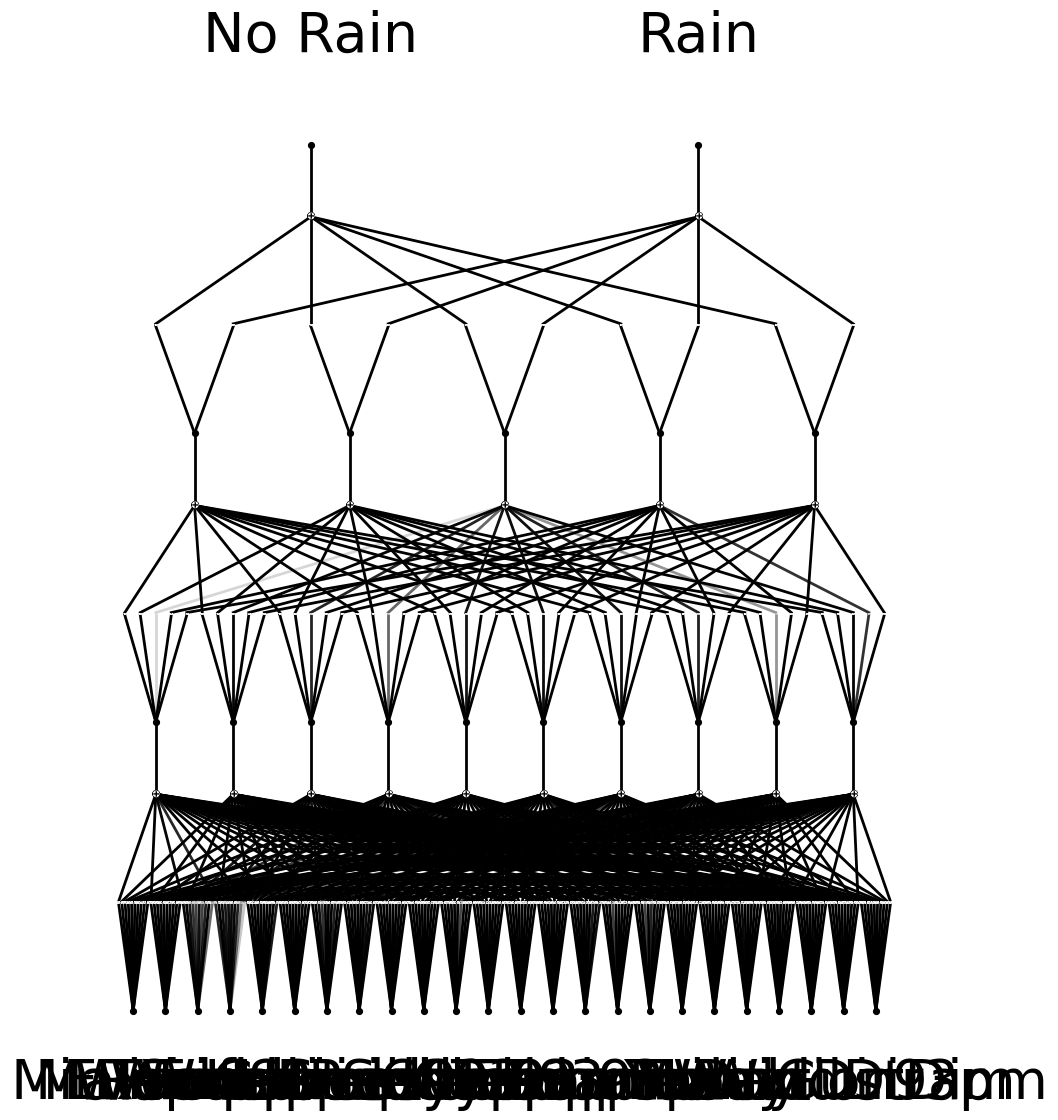

In [8]:
# Define the folder where images will be saved (if visualization is enabled)
image_folder = 'video_img'

# Define the KAN model with adjusted input and output sizes
model = KAN(width=[24, 10, 5, 2], grid=5, k=3, seed=0, device=device)

# Forward pass on training data
model(weather_dataset['train_input'])

# Plot the model structure
model.plot(beta=100, scale=1, 
           in_vars=feature_names,  # Use extracted feature names dynamically
           out_vars=['No Rain', 'Rain'])  # Binary classification labels


In [9]:
print("Unique values in train_label:", torch.unique(weather_dataset['train_label']))

Unique values in train_label: tensor([0, 1])


In [10]:
def train_acc():
    return torch.mean((torch.argmax(model(weather_dataset['train_input']), dim=1) == weather_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(weather_dataset['test_input']), dim=1) == weather_dataset['test_label']).float())


results = model.fit(weather_dataset, opt="Adam", metrics=(train_acc, test_acc),
                    loss_fn=loss_fn, steps=30, lamb=0.005, lamb_entropy=5.,
                    save_fig=False)
train_acc_final = results['train_acc'][-1]
test_acc_final = results['test_acc'][-1]

| train_loss: 7.70e-01 | test_loss: 7.82e-01 | reg: 5.17e+02 | : 100%|█| 30/30 [02:38<00:00,  5.28s/

saving model version 0.1


In [11]:
# Mostrarlas en pantalla
print(f"Train accuracy: {train_acc_final}")
print(f"Test accuracy: {test_acc_final}")

Train accuracy: 0.6868066191673279
Test accuracy: 0.684658408164978


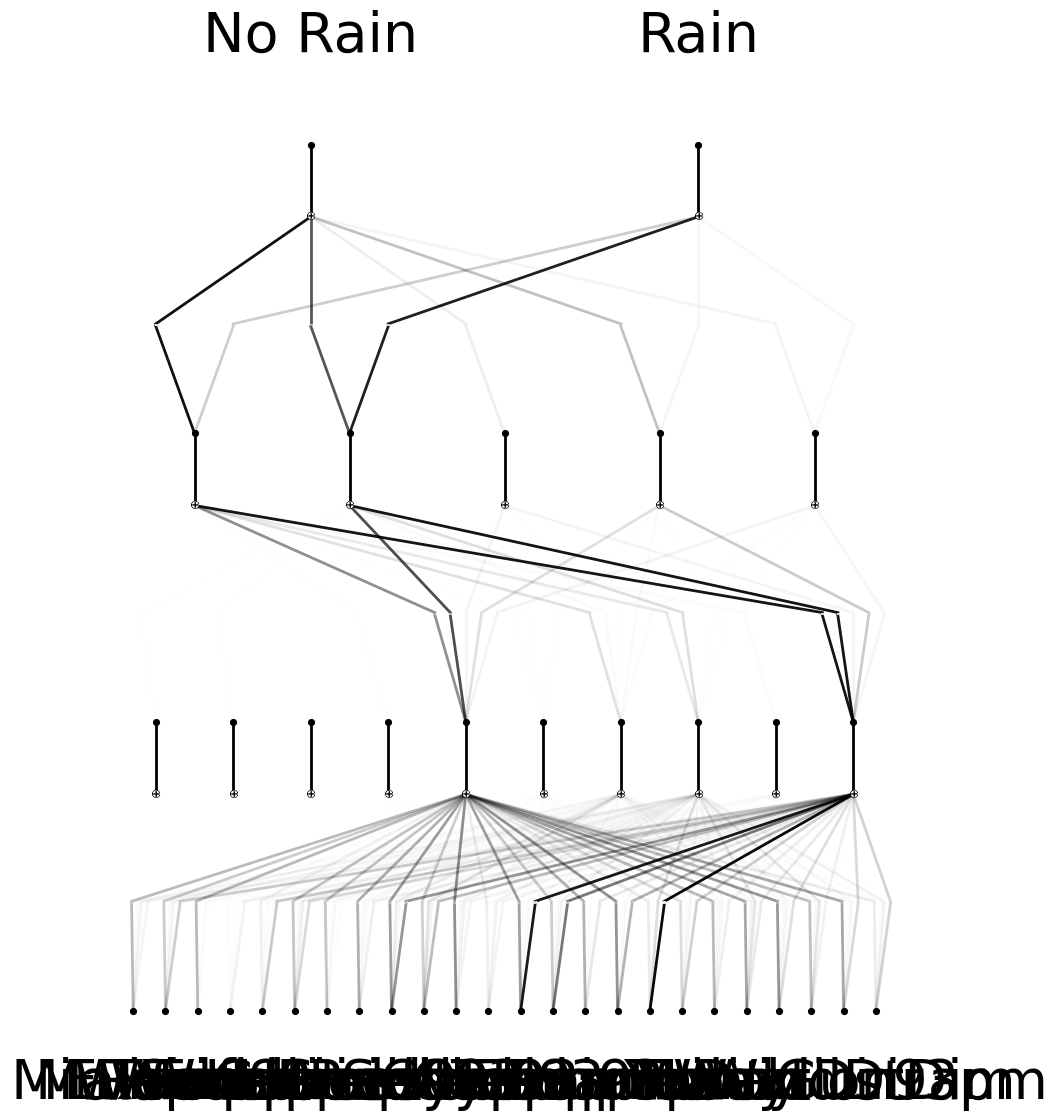

In [12]:
# Dynamically use the feature names from the dataset
model.plot(
    scale=1, 
    in_vars=feature_names,  # Use extracted feature names dynamically
    out_vars=['No Rain', 'Rain']  # Binary classification for RainToday
)


Although the prune() method is intended to simplify the model by removing inactive components, applying it in this case caused the training to break, returning NaN losses. This suggests that pruning removed essential parts of the network. To ensure stability and preserve performance, I decided not to use pruning.

In [13]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

# Predicciones del modelo (clases)
y_true = weather_dataset['test_label'].cpu().numpy()
y_pred = torch.argmax(model(weather_dataset['test_input']), dim=1).cpu().numpy()

# Para calcular AUC, necesitamos las probabilidades de la clase positiva
y_prob = torch.softmax(model(weather_dataset['test_input']), dim=1)[:, 1].detach().cpu().numpy()

# Métricas
acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)          # sensibilidad
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# Mostrar resultados
print(f"Accuracy: {acc:.4f}")
print(f"Sensibilidad (Recall): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Accuracy: 0.6847
Sensibilidad (Recall): 0.7045
F1 Score: 0.4991
AUC: 0.7555
